# OpenML CC18 Metalearning: Model Capacity

In this notebook we tune training time, layer size, and layer depth for
the controller

In [4]:
%matplotlib inline

In [5]:
import re
import tarfile
from collections import defaultdict
from typing import Dict, List, Any, Union

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import plotly.express as px
import seaborn as sns
import yaml
from IPython.display import display, Markdown

sns.set_style("whitegrid")

from pathlib import Path

In [6]:
# environment variables
JOBS = [388, 390, 391]
RESULTS_ROOT = Path("..") / "floyd_outputs"

In [7]:
# utility functions
def output_path(job):
    return RESULTS_ROOT / str(job) / "output.tar"

#### Experiment Config

In [8]:
experiment_configs = {}
for job in JOBS:
    with tarfile.open(output_path(job)) as tar:
        file = tar.extractfile(tar.getmember("./experiment_config.yml"))
        experiment_config = yaml.safe_load(file)
        experiment_configs[job] = experiment_config
    display(Markdown(f"### Experiment Config - Job: {job}"))
    print(json.dumps(experiment_config, indent=4))

### Experiment Config - Job: 388

{
    "name": "metalearn_a2c_binary_n_episodes",
    "experiment_type": "METALEARN_REINFORCE",
    "description": "metalearning with A2C architecture: n_episodes experiments",
    "created_at": "2020-03-03-21-02-38",
    "git_hash": "677b7cc",
    "parameters": {
        "datasets": null,
        "test_datasets": null,
        "output_fp": "/output",
        "input_size": 30,
        "hidden_size": 30,
        "output_size": 30,
        "n_layers": 3,
        "dropout_rate": 0.2,
        "entropy_coef": 0.1,
        "entropy_coef_anneal_to": 0.0,
        "entropy_coef_anneal_by": null,
        "normalize_reward": false,
        "gamma": 0.99,
        "meta_reward_multiplier": 1.0,
        "n_episodes": 100,
        "n_iter": 50,
        "learning_rate": 0.005,
        "optim_beta1": 0.9,
        "optim_beta2": 0.999,
        "env_sources": [
            "SKLEARN",
            "OPEN_ML",
            "AUTOSKLEARN_BENCHMARK"
        ],
        "test_env_sources": [
            "OPEN_ML_BE

### Experiment Config - Job: 390

{
    "name": "metalearn_a2c_binary_controller_depth",
    "experiment_type": "METALEARN_REINFORCE",
    "description": "metalearning with A2C architecture: controller depth experiments",
    "created_at": "2020-03-03-21-37-52",
    "git_hash": "677b7cc",
    "parameters": {
        "datasets": null,
        "test_datasets": null,
        "output_fp": "/output",
        "input_size": 60,
        "hidden_size": 60,
        "output_size": 60,
        "n_layers": 3,
        "dropout_rate": 0.2,
        "entropy_coef": 0.1,
        "entropy_coef_anneal_to": 0.0,
        "entropy_coef_anneal_by": null,
        "normalize_reward": false,
        "gamma": 0.99,
        "meta_reward_multiplier": 1.0,
        "n_episodes": 1000,
        "n_iter": 50,
        "learning_rate": 0.005,
        "optim_beta1": 0.9,
        "optim_beta2": 0.999,
        "env_sources": [
            "SKLEARN",
            "OPEN_ML",
            "AUTOSKLEARN_BENCHMARK"
        ],
        "test_env_sources": [
          

### Experiment Config - Job: 391

{
    "name": "metalearn_a2c_binary_layer_sizes",
    "experiment_type": "METALEARN_REINFORCE",
    "description": "metalearning with A2C architecture: controller layer size experiments",
    "created_at": "2020-03-03-21-36-48",
    "git_hash": "677b7cc",
    "parameters": {
        "datasets": null,
        "test_datasets": null,
        "output_fp": "/output",
        "input_size": 30,
        "hidden_size": 30,
        "output_size": 30,
        "n_layers": 3,
        "dropout_rate": 0.2,
        "entropy_coef": 0.1,
        "entropy_coef_anneal_to": 0.0,
        "entropy_coef_anneal_by": null,
        "normalize_reward": false,
        "gamma": 0.99,
        "meta_reward_multiplier": 1.0,
        "n_episodes": 1000,
        "n_iter": 50,
        "learning_rate": 0.005,
        "optim_beta1": 0.9,
        "optim_beta2": 0.999,
        "env_sources": [
            "SKLEARN",
            "OPEN_ML",
            "AUTOSKLEARN_BENCHMARK"
        ],
        "test_env_sources": [
          

## Training

In [9]:
def assign_hyperparameters(training_results, experiment_config):
    hyperparameters = experiment_config["parameters"]["hyperparameters"]
    
    if isinstance(hyperparameters, list):
        # assume that elements in the list are dictionaries mapping hyperparameter
        # names to values
        parsed_hyperparameters: Dict[str, List[Any]] = defaultdict(list)
        for key_value_map in hyperparameters:
            for k, v in key_value_map.items():
                parsed_hyperparameters[k].append(v)
        
        for name, values in parsed_hyperparameters.items():
            training_results[f"hyperparam:{name}"] = training_results.trial_num.map(
                lambda x: values[x])
        
        hyperparam_names = list(parsed_hyperparameters)

    elif isinstance(hyperparameters, dict):
        hyperparam_names = list(hyperparameters)
        # hyperparameter values should already by in the results dataframe
        for name in hyperparam_names:
            training_results = training_results.rename(
                columns={name: f"hyperparam:{name}"})
    else:
        raise ValueError(
            "expected typ dict or list for hyperparameters, "
            f"found {type(hyperparameters)}"
        )
        
    training_results["hyperparameter_names"] = ";".join(hyperparam_names)

    return training_results
    

training_results = []
for job in JOBS:
    with tarfile.open(output_path(job)) as tar:
        training_result_files = [
            m for m in tar.getmembers()
            if m.name.startswith("./metalearn_training_results_trial_")
        ]
        training_results.append(
            pd.concat([
                pd.read_csv(tar.extractfile(member))
                for member in training_result_files
            ])
            .sort_values(["trial_num", "episode"])
            .assign(job=job)
            .pipe(
                assign_hyperparameters,
                experiment_config=experiment_configs[job]
            )
        )

training_results = pd.concat(training_results, sort=True)
training_results.head(3)

,actor_losses,best_validation_scores,critic_losses,data_env_names,entropy_coefficient,entropy_losses,episode,gradient_norms,hidden_size,hyperparam:hidden_size,...,mlf_diversity,n_successful_mlfs,n_unique_hyperparams,n_unique_mlfs,output_size,scorers,std_validation_scores,target_type,total_losses,trial_num
0,1.013094,1.000000,1.277417,openml.mushroom,0.1,-0.117272,1,1.0,NaN,NaN,...,1.0,4,4,4,NaN,roc_auc,0.025749,BINARY,2.173239,0
1,2.984694,0.926603,3.992122,openml.ova_colon,0.1,-0.118459,2,1.0,NaN,NaN,...,1.0,8,8,8,NaN,roc_auc,0.140303,BINARY,6.858357,0
2,2.242075,0.807155,2.588162,openml.adult,0.1,-0.120672,3,1.0,NaN,NaN,...,1.0,7,7,7,NaN,roc_auc,0.110886,BINARY,4.709566,0


### Mean Rewards per Episode

It looks like the experiment output is missing training results
data for trials 1, 2, 3, and 6. Not sure why this happened, need
to check that the trail numbers are properly recorded in the
`metalearn.experiment` module.

In [10]:
training_results.query("episode == 1")

,actor_losses,best_validation_scores,critic_losses,data_env_names,entropy_coefficient,entropy_losses,episode,gradient_norms,hidden_size,hyperparam:hidden_size,...,mlf_diversity,n_successful_mlfs,n_unique_hyperparams,n_unique_mlfs,output_size,scorers,std_validation_scores,target_type,total_losses,trial_num
0,1.013094,1.000000,1.277417,openml.mushroom,0.1,-0.117272,1,1.0,NaN,NaN,...,1.000000,4,4,4,NaN,roc_auc,0.025749,BINARY,2.173239,0
0,12.157976,1.000000,65.080681,openml.mushroom,0.1,-0.120681,1,1.0,NaN,NaN,...,1.000000,25,25,25,NaN,roc_auc,0.128154,BINARY,77.117973,1
0,10.119901,1.000000,44.784023,openml.mushroom,0.1,-0.119458,1,1.0,NaN,NaN,...,0.952381,22,22,21,NaN,roc_auc,0.134897,BINARY,54.784466,2
0,7.633434,1.000000,27.044933,openml.mushroom,0.1,-0.116880,1,1.0,NaN,NaN,...,1.000000,18,18,18,NaN,roc_auc,0.210611,BINARY,34.561489,3
0,1.088495,0.956531,0.870986,openml.mfeat-pixel,0.1,-0.120069,1,1.0,NaN,NaN,...,1.000000,6,6,6,NaN,f1_macro,0.362816,MULTICLASS,1.839413,0
0,6.232789,0.969923,24.038603,openml.mfeat-pixel,0.1,-0.112321,1,1.0,NaN,NaN,...,0.925926,28,28,26,NaN,f1_macro,0.406998,MULTICLASS,30.159073,1
0,3.254060,0.915912,4.529334,openml.mfeat-pixel,0.1,-0.119021,1,1.0,NaN,NaN,...,1.000000,14,14,14,NaN,f1_macro,0.360432,MULTICLASS,7.664372,2
0,5.873673,0.974793,19.921780,openml.mfeat-pixel,0.1,-0.114190,1,1.0,NaN,NaN,...,0.952381,22,22,21,NaN,f1_macro,0.369365,MULTICLASS,25.681263,3
0,6.005623,1.000000,19.743341,openml.labor,0.1,-0.117129,1,1.0,30.0,30.0,...,1.000000,18,18,18,30.0,roc_auc,0.176048,BINARY,25.631836,0
0,6.788422,0.958333,20.976229,openml.labor,0.1,-0.121025,1,1.0,60.0,60.0,...,1.000000,20,20,20,60.0,roc_auc,0.184477,BINARY,27.643625,1


In [11]:
training_results.trial_num.unique()

array([0, 1, 2, 3])

In [12]:
HYPERPARAMETERS = [x for x in training_results.columns if x.startswith("hyperparam:")]

Roughly define regret as ${validation\ score}_{max} - {validation\ score}_{mean}$
for a particular episode. Where ${validation\ score}_{max}$ is the best validation
set found by all of the hyperparameter conditions for a particular dataset.

In [13]:
optimal_validation_scores = training_results.groupby("data_env_names").best_validation_scores.max()

training_results.assign(optimal_validation_scores=lambda df: df.data_env_names.map(optimal_validation_scores))

,actor_losses,best_validation_scores,critic_losses,data_env_names,entropy_coefficient,entropy_losses,episode,gradient_norms,hidden_size,hyperparam:hidden_size,...,n_successful_mlfs,n_unique_hyperparams,n_unique_mlfs,output_size,scorers,std_validation_scores,target_type,total_losses,trial_num,optimal_validation_scores
0,1.013094,1.000000,1.277417,openml.mushroom,0.1,-0.117272,1,1.0,NaN,NaN,...,4,4,4,NaN,roc_auc,0.025749,BINARY,2.173239,0,1.000000
1,2.984694,0.926603,3.992122,openml.ova_colon,0.1,-0.118459,2,1.0,NaN,NaN,...,8,8,8,NaN,roc_auc,0.140303,BINARY,6.858357,0,0.997835
2,2.242075,0.807155,2.588162,openml.adult,0.1,-0.120672,3,1.0,NaN,NaN,...,7,7,7,NaN,roc_auc,0.110886,BINARY,4.709566,0,0.935388
3,2.066700,0.762530,1.592945,openml.autos,0.1,-0.120534,4,1.0,NaN,NaN,...,11,11,10,NaN,f1_macro,0.205699,MULTICLASS,3.539111,0,0.881793
4,2.325837,0.850000,2.658253,sklearn.iris,0.1,-0.118512,5,1.0,NaN,NaN,...,12,12,12,NaN,f1_macro,0.248596,MULTICLASS,4.865579,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.000017,0.625670,122.446495,openml.kropt,0.1,-0.000001,996,1.0,120.0,120.0,...,50,1,1,120.0,f1_macro,0.036863,MULTICLASS,122.446480,3,0.747228
996,0.000438,0.860474,292.574677,openml.puma8nh,0.1,-0.000012,997,1.0,120.0,120.0,...,50,1,1,120.0,roc_auc,0.025745,BINARY,292.575104,3,0.917541
997,0.000056,0.926884,173.204773,openml.house_16h,0.1,-0.000002,998,1.0,120.0,120.0,...,50,1,1,120.0,roc_auc,0.009808,BINARY,173.204834,3,0.953467
998,-0.000337,NaN,665.639038,openml.ova_lung,0.1,-0.000010,999,1.0,120.0,120.0,...,0,0,0,120.0,roc_auc,NaN,BINARY,665.638672,3,1.000000


Are the `data_env_names` being sampled in the same order within jobs?

In [14]:
(
    training_results
    .groupby(["job", "trial_num", "episode"])
    .data_env_names.nunique()
    .pipe(lambda s: (s == 1).all())
)

True

In [15]:
notna_hyperparams = training_results.query("job == 388")[HYPERPARAMETERS].notna().all()
notna_hyperparams[notna_hyperparams].index.tolist()


['hyperparam:n_episodes']

In [16]:
METRICS = [
    "total_losses",
    "gradient_norms",
    "best_validation_scores",
    "mean_rewards",
    "mean_validation_scores",
    "n_successful_mlfs",
    "n_unique_mlfs",
    "mlf_diversity",
    "hyperparam_diversity",
]


def aggregate_results(job_training_results):
    job = job_training_results.job.iloc[0]
    hyperparameters = [
        x for x in job_training_results.columns if x.startswith("hyperparam:")]
    notna_hyperparams = job_training_results[hyperparameters].notna().all()
    hyperparameters = notna_hyperparams[notna_hyperparams].index.tolist()
    
    def _format_trial_info(df, hyperparameters):
        trial_info = pd.Series([f"job={job}; "] * df.shape[0], index=df.index)
        for i, h in enumerate(hyperparameters):
            trial_info = trial_info.str.cat(
                f"{h.replace('hyperparam:', '')}=" + df[h].astype(str)
            )
            if i + 1 < len(hyperparameters):
                trial_info = trial_info + "; "
        return trial_info
    
    return (
        job_training_results
        # get rank by mean validation scores
        .sort_values(["episode", "mean_validation_scores"], ascending=[True, False])
        .groupby("episode")
        .apply(lambda group: group.assign(rank_mean_validation_score=range(1, group.shape[0] + 1)))
        .reset_index(drop=True)
        # get rank by best validation score
        .sort_values(["episode", "best_validation_scores"], ascending=[True, False])
        .groupby("episode")
        .apply(lambda group: group.assign(rank_best_validation_score=range(1, group.shape[0] + 1)))
        .reset_index(drop=True)
        # compute regret
        .assign(
            optimal_validation_scores=lambda df: df.data_env_names.map(
                job_training_results.groupby("data_env_names").best_validation_scores.max())
        )
        .assign(regret=lambda df: df.optimal_validation_scores - df.mean_validation_scores)
        .groupby(["trial_num"] + hyperparameters)
        # compute cumulative metrics
        .apply(
            lambda df: df.assign(
                cum_regret=df.regret.cumsum(),
                cum_rank_mean_validation_score=df.rank_mean_validation_score.cumsum(),
                cum_rank_best_validation_score=df.rank_best_validation_score.cumsum(),
            )
        )
        .reset_index(drop=True)
        .assign(trial_info=lambda df: _format_trial_info(df, hyperparameters))
        # compute exponentially-weighted mean of metrics
        .pipe(lambda df: pd.concat([
            df,
            (
                df
                .set_index(["trial_info", "episode"])
                .groupby("trial_info")
                .apply(lambda df: df[METRICS].ewm(alpha=0.005).mean())
                .rename(columns={m: f"ewm_{m}" for m in METRICS})
                .reset_index(drop=True)
            )
        ], sort=False, axis=1))
        .reset_index(drop=True)
    )


agg_performance_results = (
    training_results
    .groupby("job")
    .apply(aggregate_results)
    .reset_index(drop=True)
)

agg_performance_results.head()

,actor_losses,best_validation_scores,critic_losses,data_env_names,entropy_coefficient,entropy_losses,episode,gradient_norms,hidden_size,hyperparam:hidden_size,...,trial_info,ewm_total_losses,ewm_gradient_norms,ewm_best_validation_scores,ewm_mean_rewards,ewm_mean_validation_scores,ewm_n_successful_mlfs,ewm_n_unique_mlfs,ewm_mlf_diversity,ewm_hyperparam_diversity
0,1.013094,1.000000,1.277417,openml.mushroom,0.1,-0.117272,1,1.0,NaN,NaN,...,job=388; n_episodes=500.0,2.173239,1.0,1.000000,0.078752,0.984400,4.000000,4.000000,1.000000,1.0
1,2.984694,0.926603,3.992122,openml.ova_colon,0.1,-0.118459,2,1.0,NaN,NaN,...,job=388; n_episodes=500.0,4.521669,1.0,0.963210,0.089737,0.806337,6.005013,6.005013,1.000000,1.0
2,2.242075,0.807155,2.588162,openml.adult,0.1,-0.120672,3,1.0,NaN,NaN,...,job=388; n_episodes=500.0,4.584616,1.0,0.910930,0.087126,0.732296,6.338339,6.338339,1.000000,1.0
3,2.066700,0.762530,1.592945,openml.autos,0.1,-0.120534,4,1.0,NaN,NaN,...,job=388; n_episodes=500.0,4.321271,1.0,0.873551,0.081648,0.622693,7.512531,7.260648,0.974812,1.0
4,2.325837,0.850000,2.658253,sklearn.iris,0.1,-0.118512,5,1.0,NaN,NaN,...,job=388; n_episodes=500.0,4.431227,1.0,0.868793,0.081893,0.566648,8.419045,8.218045,0.979900,1.0


In [17]:
job_trial_num_df = (
    agg_performance_results[["job", "trial_num", "trial_info"]]
)
job_trial_num_df

,job,trial_num,trial_info
0,388,0,job=388; n_episodes=500.0
1,388,0,job=388; n_episodes=500.0
2,388,0,job=388; n_episodes=500.0
3,388,0,job=388; n_episodes=500.0
4,388,0,job=388; n_episodes=500.0
...,...,...,...
12995,391,3,job=391; hidden_size=120.0; input_size=120.0; ...
12996,391,3,job=391; hidden_size=120.0; input_size=120.0; ...
12997,391,3,job=391; hidden_size=120.0; input_size=120.0; ...
12998,391,3,job=391; hidden_size=120.0; input_size=120.0; ...


#### Cumulative Regret

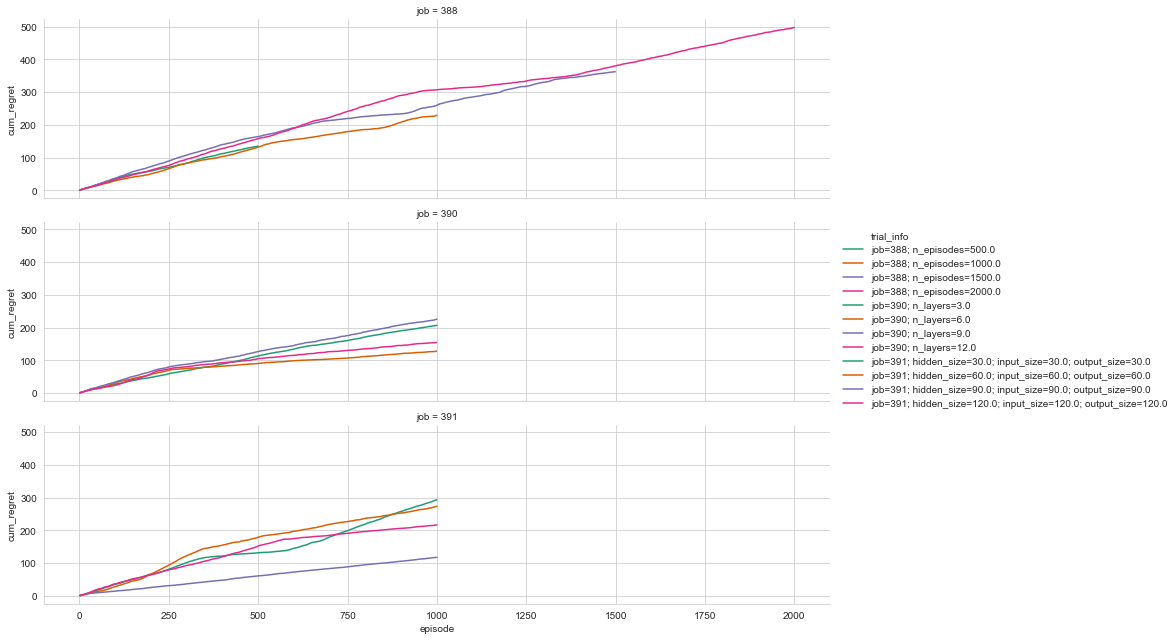

In [23]:
PALETTE = sns.color_palette("Dark2", 4) * 3

g = sns.relplot(
    data=agg_performance_results,
    kind="line",
    x="episode",
    y="cum_regret",
    row="job",
    hue="trial_info",
    palette=PALETTE,
    legend="full",
    height=3,
    aspect=4,
)

#### Cumulative Rank Mean Validation Score

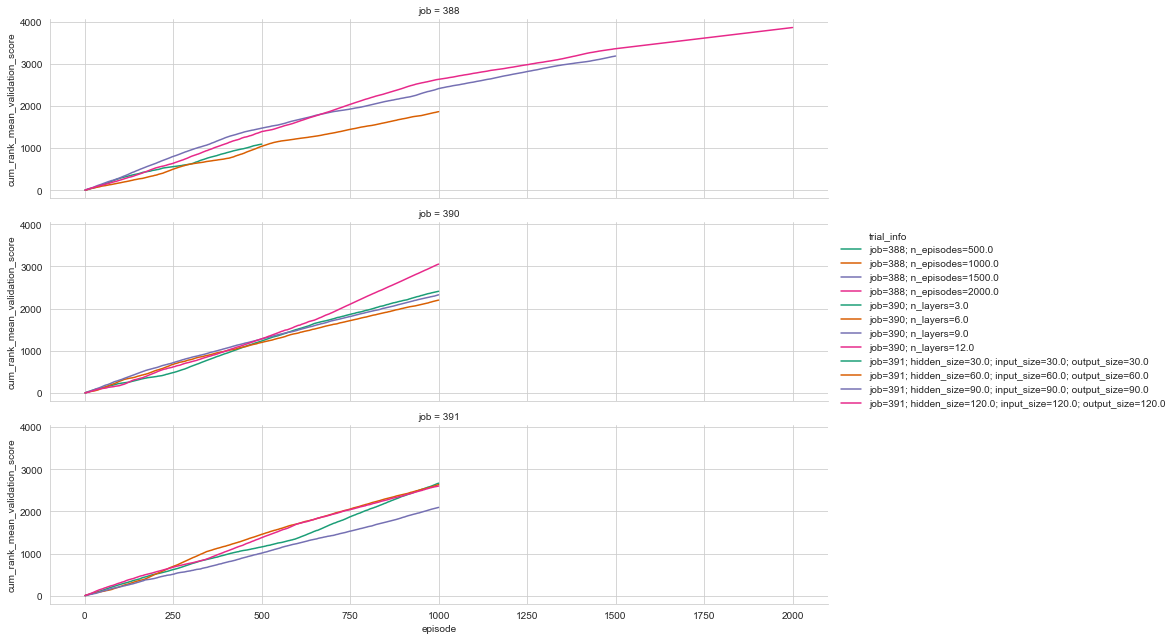

In [24]:
g = sns.relplot(
    data=agg_performance_results,
    kind="line",
    x="episode",
    y="cum_rank_mean_validation_score",
    row="job",
    hue="trial_info",
    palette=PALETTE,
    legend="brief",
    height=3,
    aspect=4,
)

#### ewm best validation scores

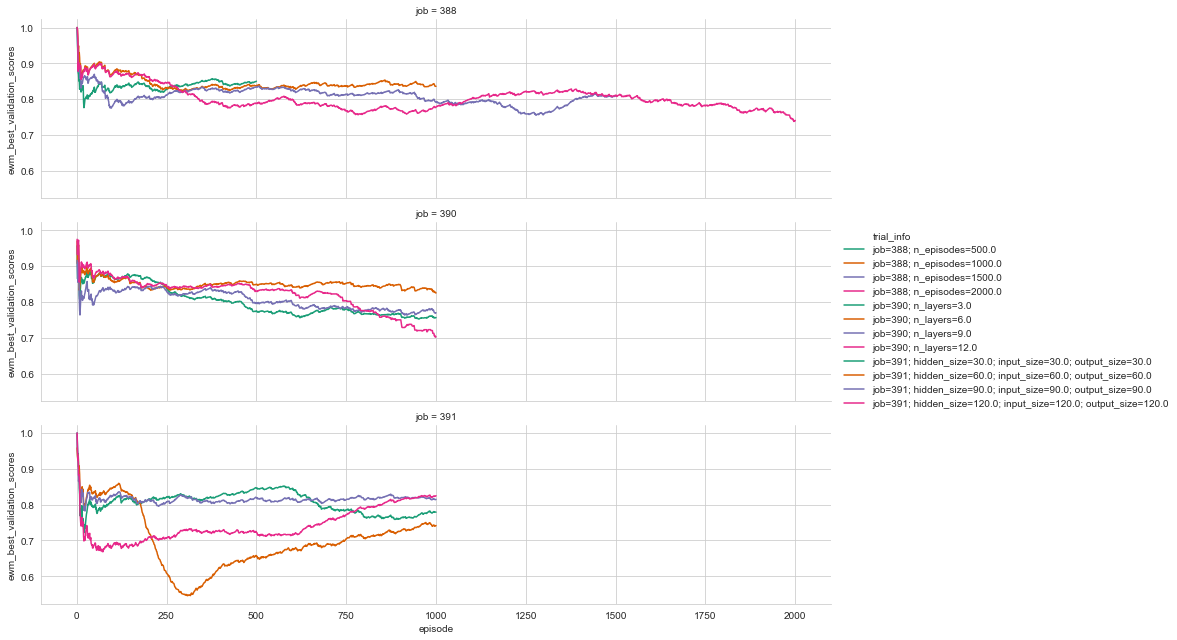

#### ewm mean rewards

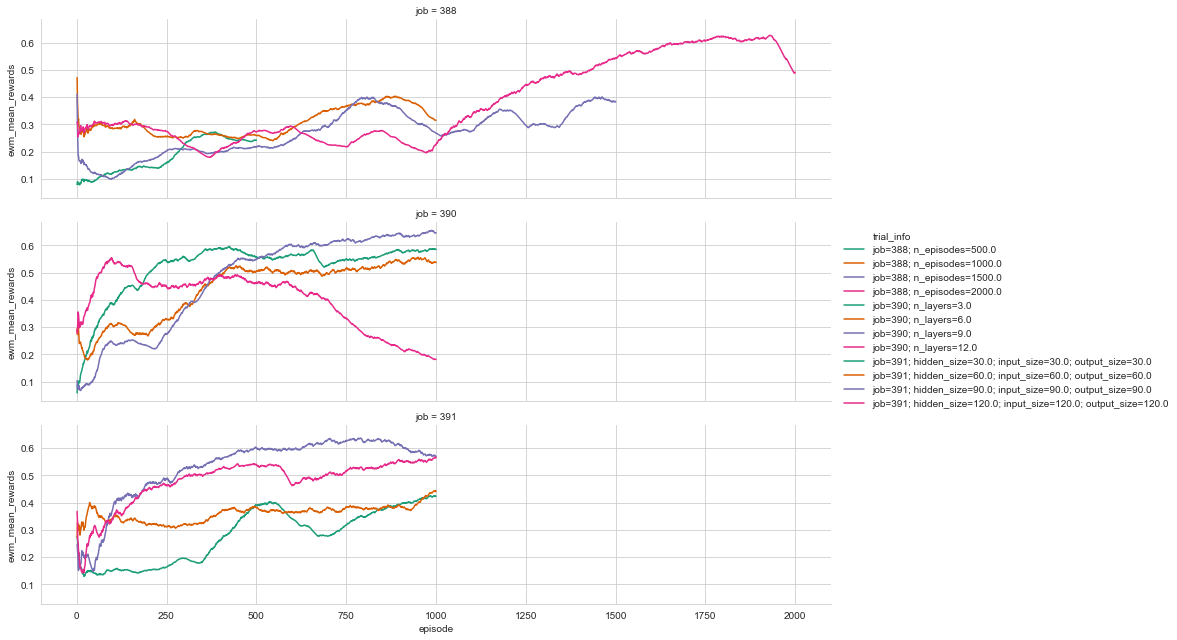

#### ewm mean validation scores

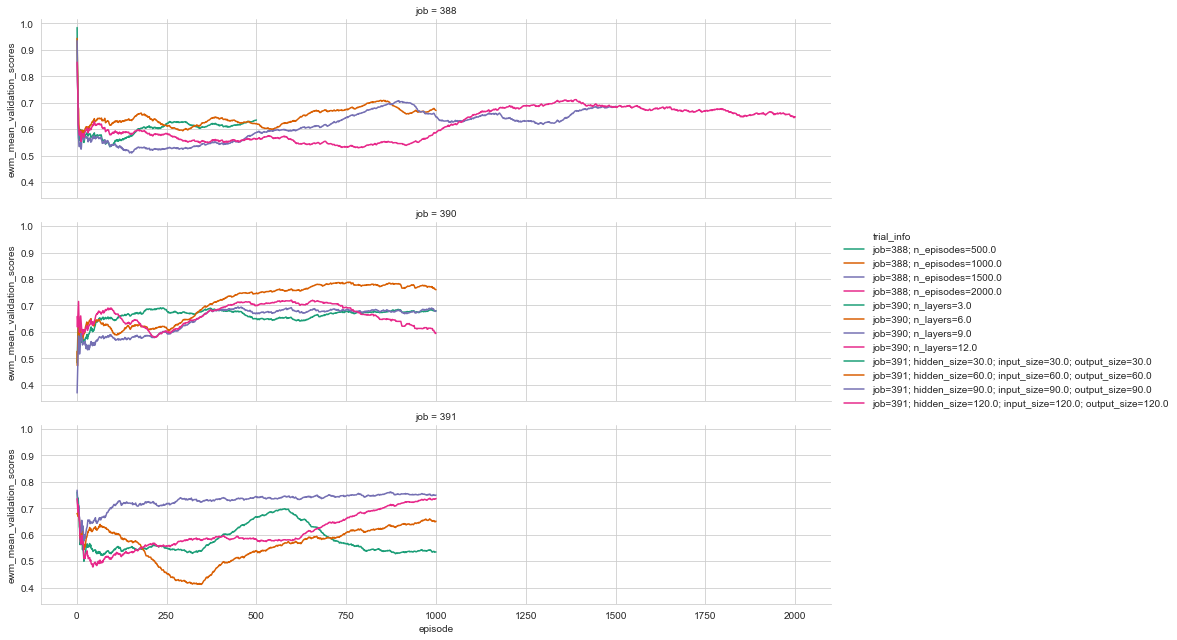

#### ewm n successful mlfs

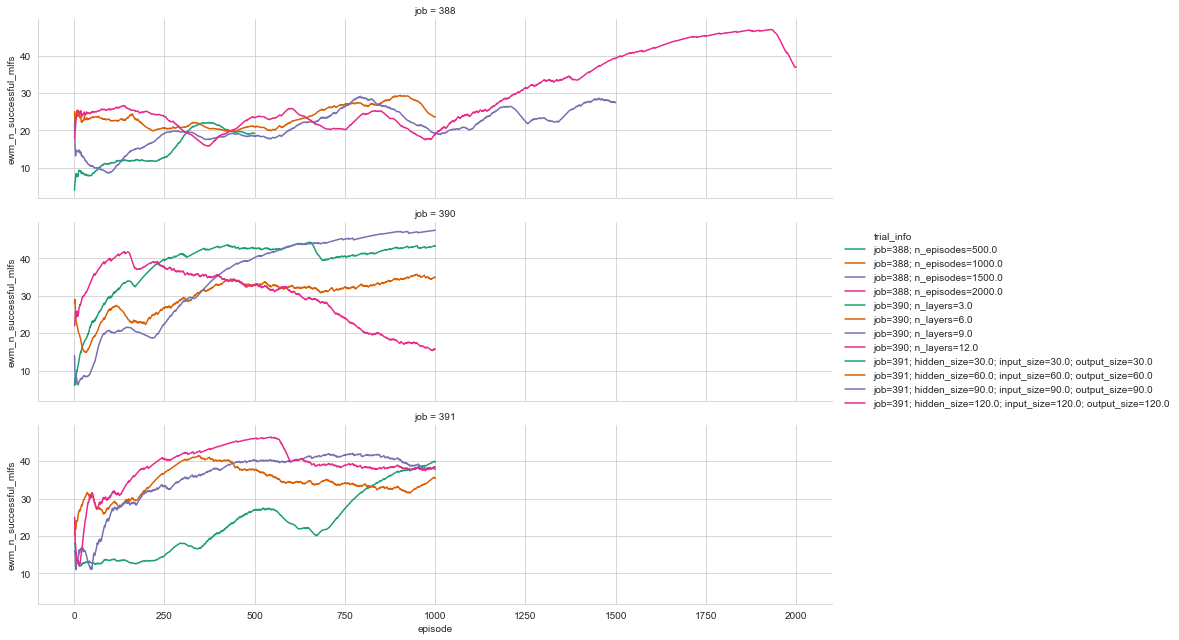

#### ewm n unique mlfs

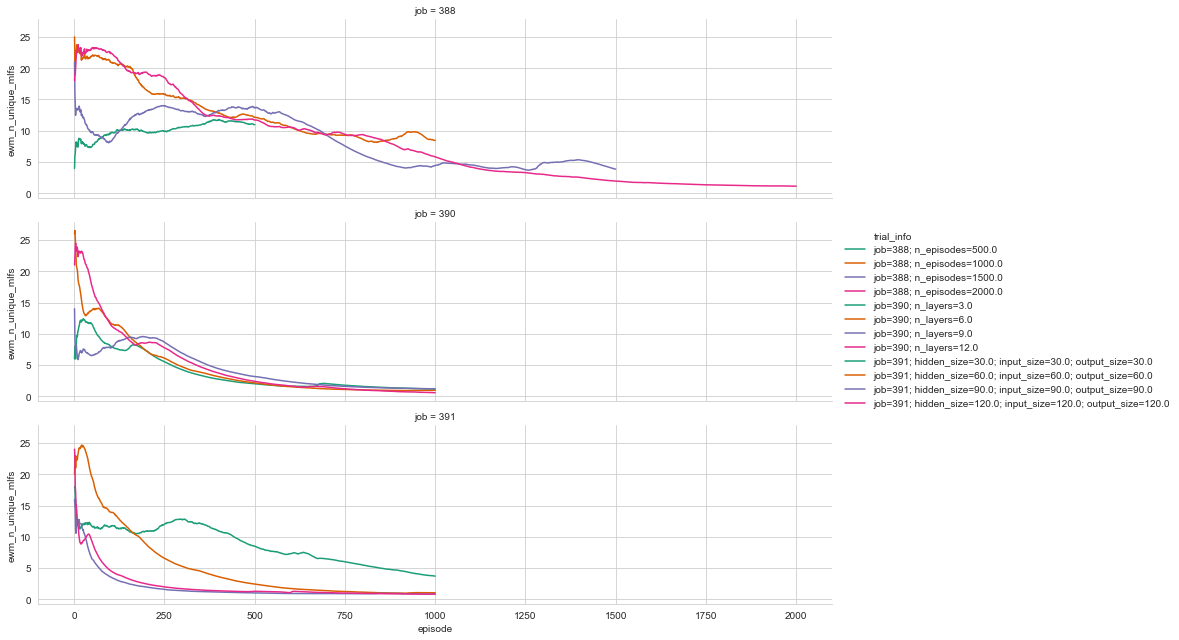

In [21]:
PLOT_METRICS = [
    "ewm_best_validation_scores",
    "ewm_mean_rewards",
    "ewm_mean_validation_scores",
    "ewm_n_successful_mlfs",
    "ewm_n_unique_mlfs",
]

for metric in PLOT_METRICS:
    display(Markdown(f"#### {' '.join(metric.split('_'))}"))
    g = sns.relplot(
        data=agg_performance_results,
        kind="line",
        x="episode",
        y=metric,
        row="job",
        hue="trial_info",
        height=3,
        aspect=4,
        palette=PALETTE,
        legend="brief",
    )
    plt.show()

#### Plot Performance vs. Number of Attempts

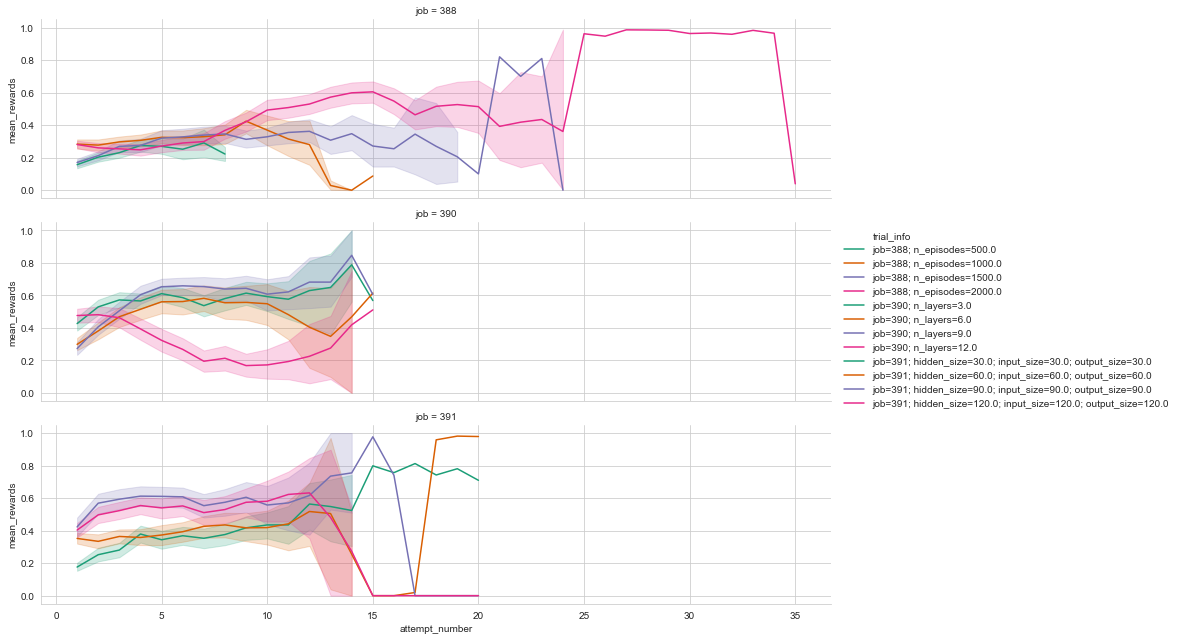

In [68]:
plot_df = (
    agg_performance_results
    .sort_values(["job", "trial_num"])
    .groupby(["job", "trial_num", "data_env_names"])
    .apply(lambda df: df.assign(attempt_number=range(1, df.shape[0] + 1)))
    .reset_index(drop=True)
)

sns.relplot(
    x="attempt_number",
    y="mean_rewards",
    kind="line",
    data=plot_df,
    row="job",
    hue="trial_info",
    palette=PALETTE,
    height=3,
    aspect=4,
)

## Inference

In [27]:
check_betw_zero_one = pa.Check(lambda s: (0.0 <= s) & (s <= 1.0))

INFERENCE_RESULT_SCHEMA = pa.DataFrameSchema(
    columns={
        "data_env": pa.Column(pa.String),
        "n_inference_steps": pa.Column(pa.Int),
        "is_valid": pa.Column(pa.Bool),
        "reward": pa.Column(pa.Float),
        "validation_score": pa.Column(pa.Float),
    },
    coerce=True,
)

@pa.check_output(INFERENCE_RESULT_SCHEMA)
def data_to_longform(inference_results):
    df = (
        inference_results
        [["data_env_partition", "trial_num",
          "data_env", "n_inference_steps", "key", "value"]]
        .pivot_table(
            index=[
                "data_env_partition", "trial_num",
                "data_env", "n_inference_steps",
            ],
            columns="key",
            values="value",
            aggfunc=lambda x: x,
        )
        .reset_index()
    )
    return (
        df
        .loc[
            lambda df: (
                # all scores should be strings
                df.validation_score.map(lambda x: isinstance(x, str)) &
                df.mlf.map(lambda x: isinstance(x, str)) &
                df.reward.map(lambda x: isinstance(x, str)) &
                df.is_valid.map(lambda x: isinstance(x, str))
            )
        ]
        .rename_axis(None, axis=1)
        .reset_index(drop=True)
    )

In [28]:
inference_results = []
for job in JOBS:
    with tarfile.open(output_path(job)) as tar:
        raw_results = pd.concat([
            (
                pd.read_csv(tar.extractfile(member))
                .assign(
                    data_env_partition=env,
                    trial_num=int(
                        re.search(
                            r".+_trial_(?P<trial_num>[0-9])\.csv",
                            str(member.name)
                        ).group("trial_num")
                    )
                )
            )
            for env in ["training", "test"]
            for member in (
                m for m in tar.getmembers()
                if m.name.startswith(f"./{env}_env_inference_results_trial_")
            )
        ])
    inference_results.append(
        raw_results
        .pipe(data_to_longform)
        .sort_values(["data_env_partition", "trial_num", "n_inference_steps"])
        # add exponentially-weighted metrics
        .groupby(["data_env_partition", "data_env"])
        .apply(
            lambda group: group.assign(
                ewm_validation_score=group.ewm(span=30).validation_score.mean()
            )
        )
        .reset_index(drop=True)
        .assign(
            job=job,
            ewm_validation_score_centered=lambda df: (
                df.ewm_validation_score - (
                    df.groupby(["data_env_partition", "data_env"])
                    .ewm_validation_score.transform("first")
                )
            ),
            target_type=lambda df: df.target_type.str.replace("^TargetType.", "")
        )
    )

inference_results = (
    pd.concat(inference_results)
    .merge(
        job_trial_num_df.assign(
            trial_info=lambda df: df.trial_info.str.split("; ").str[1:].map(lambda x: "; ".join(x))
        ),
        on=["job", "trial_num"],
        how="left"
    )
)
inference_results.head()

,data_env_partition,trial_num,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,ewm_validation_score,job,ewm_validation_score_centered,trial_info
0,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
1,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
2,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
3,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
4,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0


## Plot Best Validation Scores on Training and Test Dataset Splits

In [29]:
total_n_shots = inference_results.n_inference_steps.max()
display(Markdown(f"Number of shots per trial: {total_n_shots}"))

Number of shots per trial: 99

In [31]:
inference_results.head()

,data_env_partition,trial_num,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,ewm_validation_score,job,ewm_validation_score_centered,trial_info
0,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
1,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
2,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
3,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0
4,test,0,kaggle.poker_rule_induction,0,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.077265,f1_macro,MULTICLASS,0.077265,0.077265,388,0.0,n_episodes=500.0


In [37]:
GROUPBY_COLS = ["data_env_partition", "job", "target_type", "trial_num", "trial_info"]

inference_results_cum_reward = (
    inference_results
    .groupby(GROUPBY_COLS + ["n_inference_steps"])
    .agg({"reward": ["mean"], "mlf": ["count", "nunique"]})
    .set_axis(
        ["mean_reward", "n_successful_mlfs", "n_unique_mlfs"],
        axis="columns", inplace=False)
    .reset_index()
    .groupby(GROUPBY_COLS)
    .apply(
        lambda df: (
            df.sort_values("n_inference_steps")
            .assign(
                cumulative_reward=lambda x: x.mean_reward.cumsum(),
                cumulative_n_successful_mlfs=lambda x: x.n_successful_mlfs.cumsum(),
            )
        )
    )
    .reset_index(drop=True)
)

inference_results_cum_reward.head()

,data_env_partition,job,target_type,trial_num,trial_info,n_inference_steps,mean_reward,n_successful_mlfs,n_unique_mlfs,cumulative_reward,cumulative_n_successful_mlfs
0,test,388,BINARY,0,n_episodes=500.0,0,0.754241,9000,11,0.754241,9000
1,test,388,BINARY,0,n_episodes=500.0,1,0.701848,6500,9,1.456090,15500
2,test,388,BINARY,0,n_episodes=500.0,2,0.709607,8000,10,2.165696,23500
3,test,388,BINARY,0,n_episodes=500.0,3,0.718910,8000,10,2.884606,31500
4,test,388,BINARY,0,n_episodes=500.0,4,0.700480,9500,10,3.585087,41000


### N-shot Learning Metrics

Evaluate the performance of each learning rate on the training dataset and
test dataset splits to assess generalization performance of the metalearning
system.

#### Cumulative Reward

### Job: 388

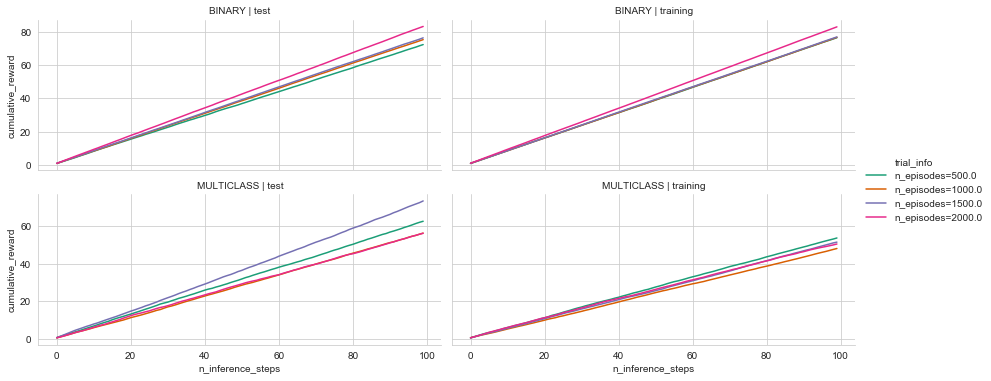

### Job: 390

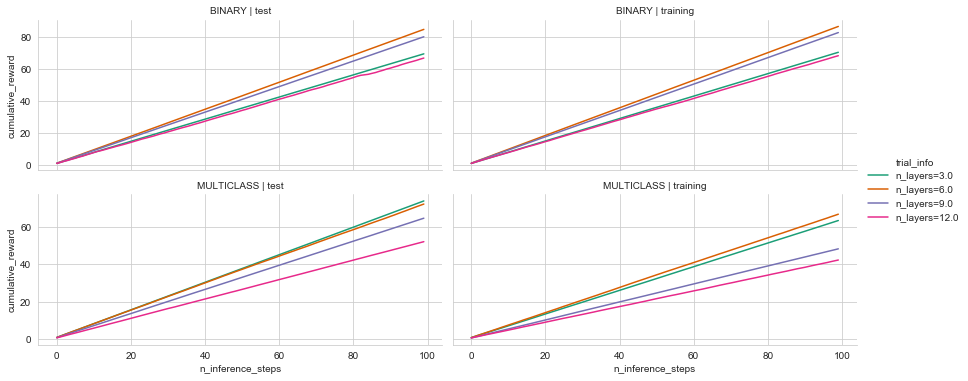

### Job: 391

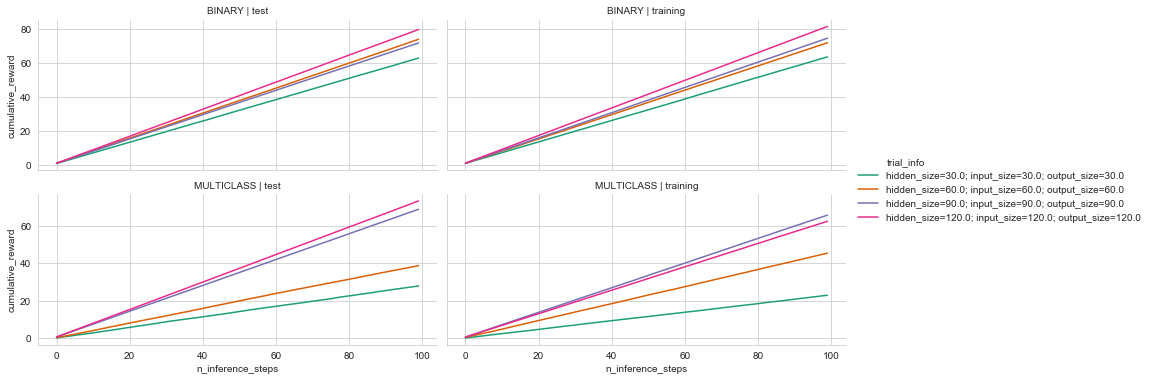

In [43]:
for job, df in inference_results_cum_reward.groupby("job"):
    display(Markdown(f"### Job: {job}"))
    g = sns.relplot(
        x="n_inference_steps",
        y="cumulative_reward",
        hue="trial_info",
        col="data_env_partition",
        row="target_type",
        row_order=["BINARY", "MULTICLASS"],
        kind="line",
        data=df,
        height=2.7,
        aspect=2.25,
        facet_kws={
            "sharey": "row",
        },
        palette=PALETTE[:4],
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.show()

#### Validation Score

### Job: 388

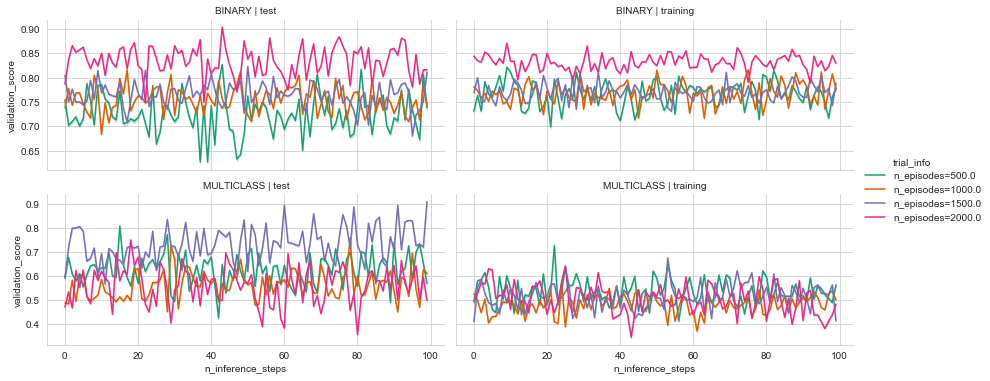

### Job: 390

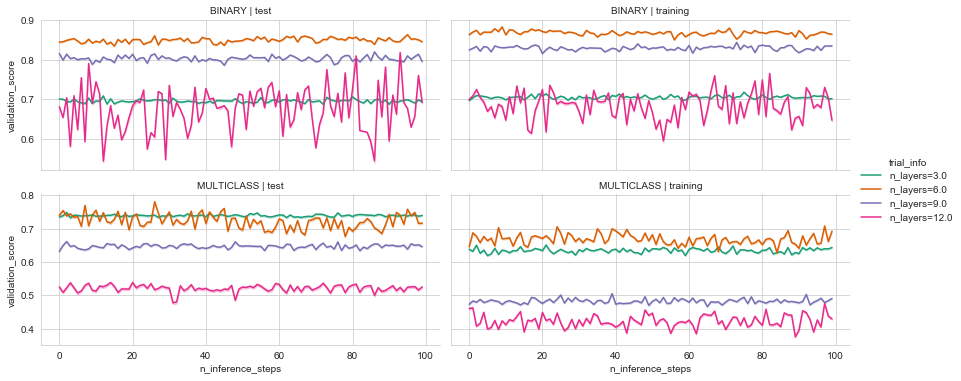

### Job: 391

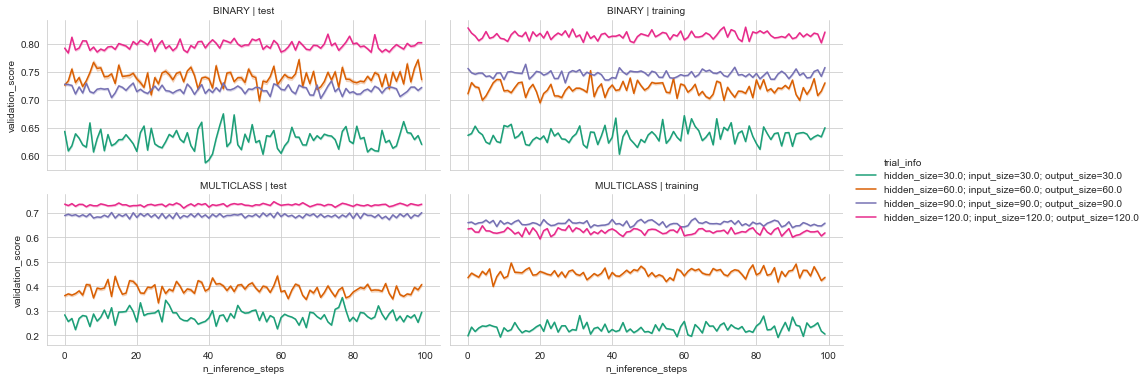

In [47]:
for job, df in inference_results.groupby("job"):
    display(Markdown(f"### Job: {job}"))
    g = sns.relplot(
        x="n_inference_steps",
        y="validation_score",
        hue="trial_info",
        col="data_env_partition",
        row="target_type",
        row_order=["BINARY", "MULTICLASS"],
        kind="line",
        data=df,
        height=2.7,
        aspect=2.25,
        facet_kws={
            "sharey": "row",
        },
        palette=PALETTE[:4],
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.show()

#### Cumulative Sum of Successful ML Frameworks

### Job: 388

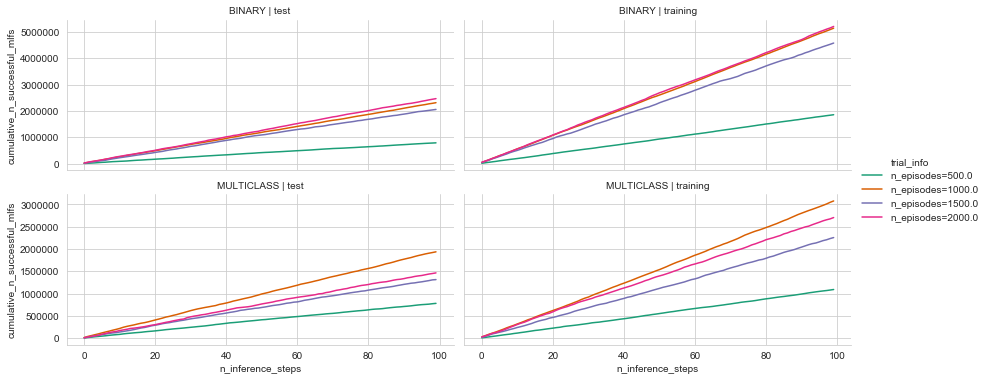

### Job: 390

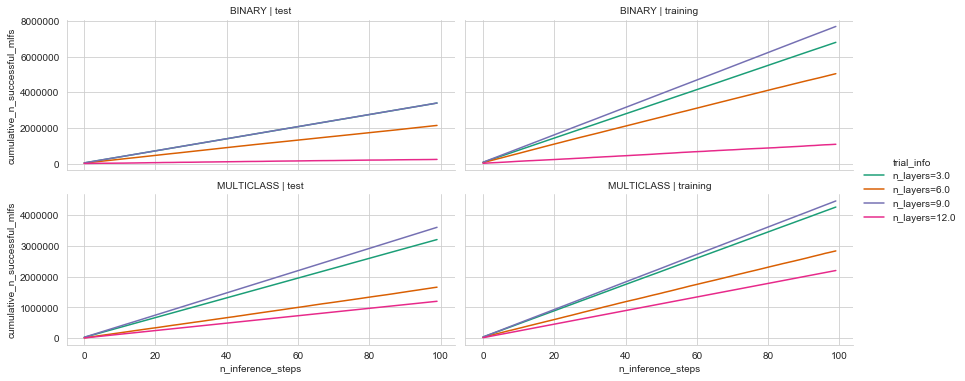

### Job: 391

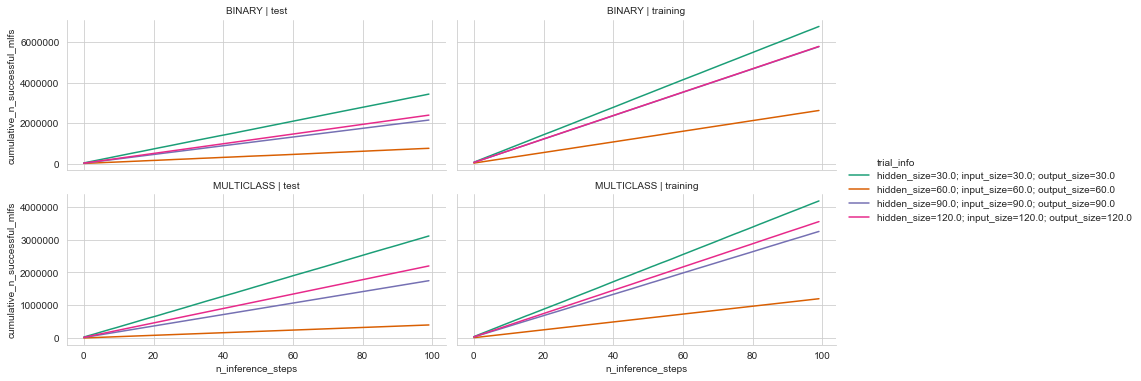

In [48]:
for job, df in inference_results_cum_reward.groupby("job"):
    display(Markdown(f"### Job: {job}"))
    g = sns.relplot(
        x="n_inference_steps",
        y="cumulative_n_successful_mlfs",
        hue="trial_info",
        col="data_env_partition",
        row="target_type",
        row_order=["BINARY", "MULTICLASS"],
        kind="line",
        data=df,
        height=2.7,
        aspect=2.25,
        facet_kws={
            "sharey": "row",
        },
        palette=PALETTE[:4],
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.show()

#### Number of Unique ML Frameworks

### Job: 388

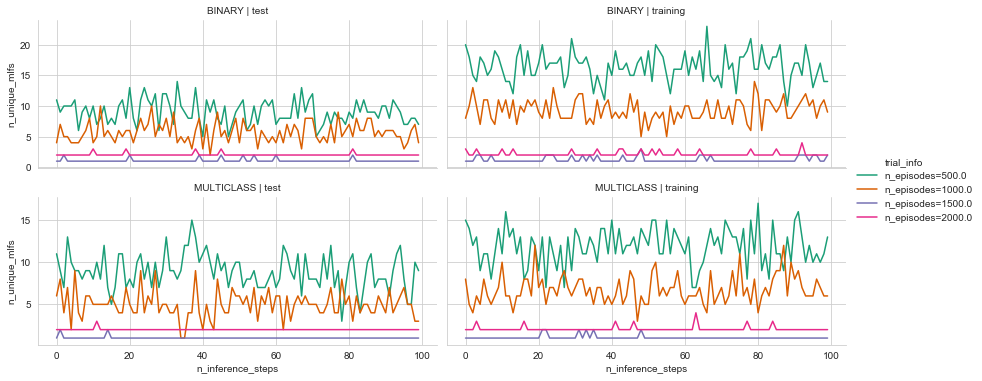

### Job: 390

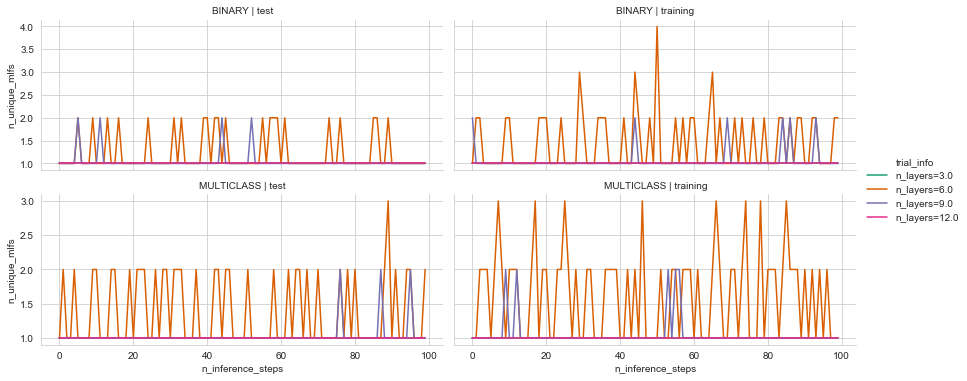

### Job: 391

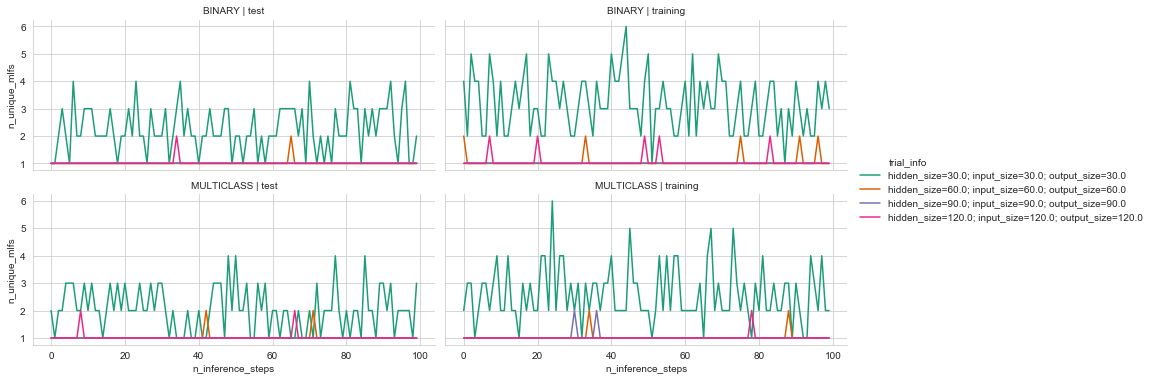

In [49]:
for job, df in inference_results_cum_reward.groupby("job"):
    display(Markdown(f"### Job: {job}"))
    g = sns.relplot(
        x="n_inference_steps",
        y="n_unique_mlfs",
        hue="trial_info",
        col="data_env_partition",
        row="target_type",
        row_order=["BINARY", "MULTICLASS"],
        kind="line",
        data=df,
        height=2.7,
        aspect=2.25,
        facet_kws={
            "sharey": "row",
        },
        palette=PALETTE[:4],
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.show()

In [39]:
def compute_n_shot_performance_metrics(inference_results, n_shots_iter):
    return pd.concat([
        inference_results
        .query("n_inference_steps <= @n_shots")
        .groupby(["data_env_partition", "data_env", "job", "trial_num", "trial_info", "target_type"])
        .agg({"validation_score": ["max", "mean"], "reward": ["max", "mean"]})
        .set_axis(
            ["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"],
            axis="columns", inplace=False)
        .reset_index()
        .assign(n_shots=n_shots)
        for n_shots in n_shots_iter
    ], ignore_index=True)


def n_shots_to_long(n_shot_performance_metrics):
    return n_shot_performance_metrics.melt(
        id_vars=["n_shots", "data_env_partition", "data_env", "job", "trial_num", "trial_info", "target_type"],
        value_vars=["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"],
        value_name="score",
        var_name="score_type"
    )

In [60]:
# main numbers to look at:
# zero-, one-, ten-, and one-hundred-shot learning
n_shot_main_metrics = (
    compute_n_shot_performance_metrics(inference_results, [0, 1, 10, 100])
    .pipe(n_shots_to_long)
    .sort_values(["job", "trial_num"])
)
n_shot_main_metrics.head(1)

,n_shots,data_env_partition,data_env,job,trial_num,trial_info,target_type,score_type,score
1,0,test,kaggle.poker_rule_induction,388,0,n_episodes=500.0,MULTICLASS,max_validation_score,0.077265


### Job: 388

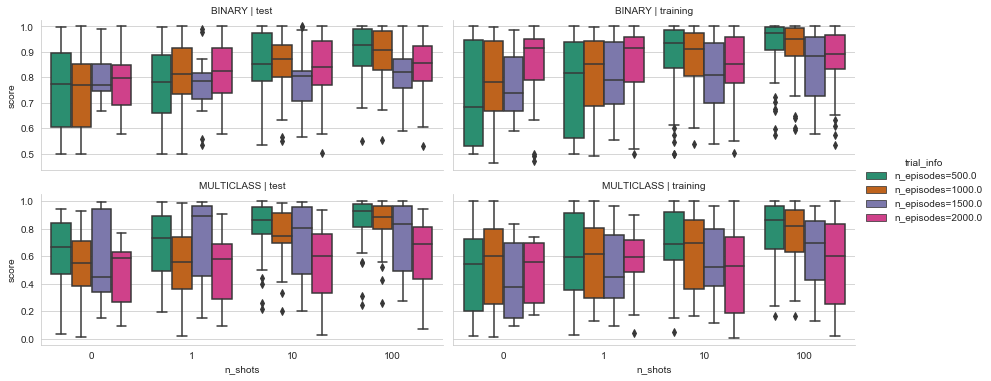

### Job: 390

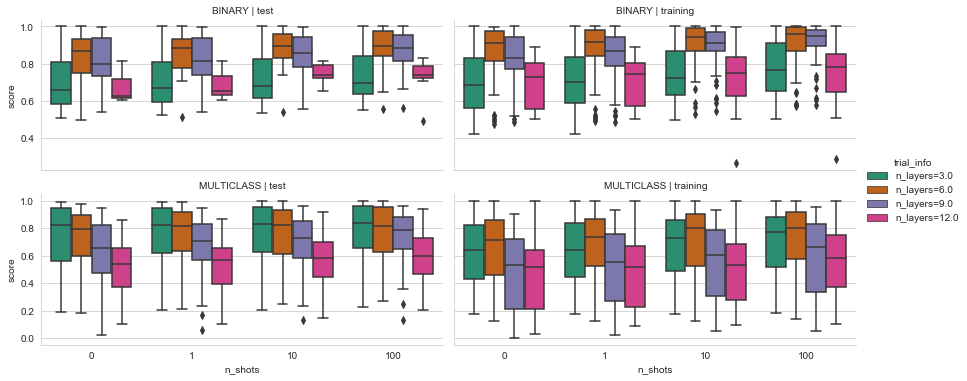

### Job: 391

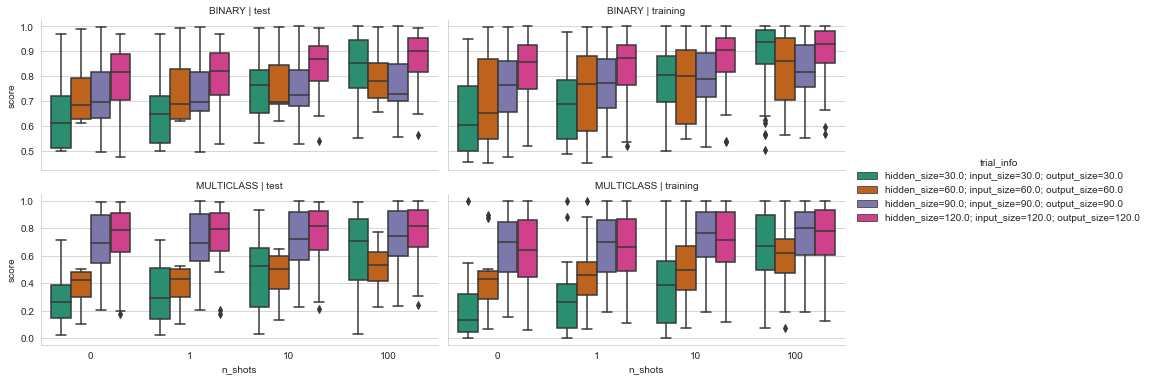

In [61]:
for job, df in n_shot_main_metrics.groupby("job"):
    display(Markdown(f"### Job: {job}"))
    g = sns.catplot(
        x="n_shots",
        y="score",
        hue="trial_info",
        row="target_type",
        row_order=["BINARY", "MULTICLASS"],
        col="data_env_partition",
        kind="box",
        sharey="row",
        data=df.query("score_type == 'max_validation_score'"),
        height=2.7,
        aspect=2.25,
        palette=PALETTE,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.show()